In [52]:
import numpy as np
import pandas as pd
from scipy import integrate
import dabest
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import NMF
my_color_palette =  {'Dz 5mg/kg':'#8FB996','NaCl':'#594157', 'PTZ 20mg/kg':'#c7991a'}

In [53]:
# In an example animal, load the single pulse data across all channels 
animal = 'Ent_CamK2_09'
SP_df_animal =  pd.read_pickle('Mice_data/'+animal+'_SP_df')
list_channel =  pd.read_pickle('Mice_data/'+animal+'_list_channel').array

In [54]:
# Apply non-negative matrix factorization (NMF) to evoked response to single pulse
def get_nnmf(V, rank, it=2000):
    # Sklearn implementation of the NMF algorithm
    # V : input matrix (size N_electrodes x N_stimulations)
    # W : basis functions W (size N_electrodes  x Rank) 
    # H : activation function (size N_stimulations x Rank)
    W = np.zeros((V.shape[0], rank))
    V[np.isnan(V)] = 0 #transfrom nan in 0
    V0 = np.delete(V, np.where(V == np.nan)[0], 0) #Remove column with only zeros

    model = NMF(n_components=rank, init='random', max_iter=it)
    W0 = model.fit_transform(V0)
    H = model.components_
    W[np.where(np.mean(V, 1) > 0)[0], :] = W0

    return W, H

input_NMF = np.transpose(np.array(SP_df_animal.loc[:, list_channel]))
rank = 1 # Number of different basis functions allowed
W, H = get_nnmf(input_NMF, rank)

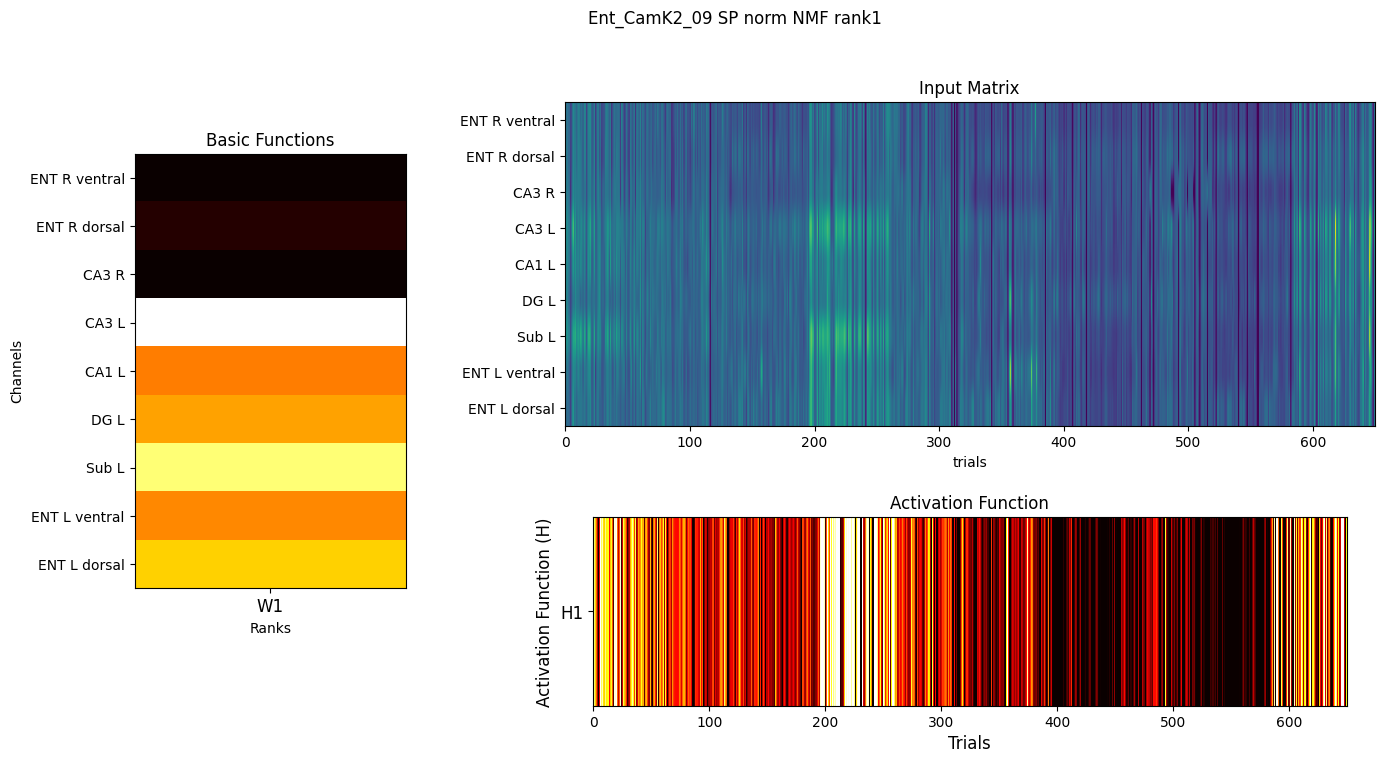

In [55]:
# Plot input matrix, basis functions and activation coefficient
title = animal + ' SP norm NMF rank' + str(rank)
fig1 = plt.figure(title, figsize=(16, 8)).suptitle(title)
gridspec.GridSpec(12, 12)

ax1 = plt.subplot2grid((12, 12), (0, 4), rowspan=7, colspan=8)
ax1.set_title('Input Matrix')
aspect_M = input_NMF.shape[1] / 20 * 8 / input_NMF.shape[0]
ax1.imshow(input_NMF, aspect=aspect_M)
if list_channel:
    ax1.set_yticks(np.arange(len(list_channel)))
    ax1.set_yticklabels(list_channel)
ax1.set_xlabel('trials')

aspect_W = W.shape[1] / 5 * 8 / W.shape[0]
ax2 = plt.subplot2grid((12, 12), (0, 0), rowspan=11, colspan=3)
ax2.set_title('Basic Functions')
ax2.imshow(W, aspect=aspect_W, vmin=np.percentile(W, 20), vmax=np.percentile(W, 95), cmap='hot')
ax2.set_ylabel('Channels')
ax2.set_xlabel('Ranks')
H_col = []
for i in range(W.shape[1]):
    H_col.append('W' + str(i + 1))
ax2.set_xticks(np.arange(W.shape[1]))
ax2.set_xticklabels(H_col, fontsize=12)
if list_channel:
    ax2.set_yticks(np.arange(len(W)))
    ax2.set_yticklabels(list_channel)

# plot activation functions
aspect_H = H.shape[1] /20 * 5 / H.shape[0]
ax3 = plt.subplot2grid((12, 12), (8, 4), rowspan=4, colspan=8, sharex=ax1)
ax3.set_title('Activation Function')
ax3.imshow(H, aspect=aspect_H, vmin=np.percentile(H, 20), vmax=np.percentile(H, 95), cmap='hot')  # , vmin=0, vmax=15
ax3.set_ylabel('Activation Function (H)', fontsize=12)
ax3.set_xlabel('Trials', fontsize=12)
W_col = []
for i in range(H.shape[0]):
    W_col.append('H' + str(i + 1))
ax3.set_yticks(np.arange(len(H)))
ax3.set_yticklabels( W_col, fontsize=12)

plt.subplots_adjust(hspace=0.9, wspace=0.9)

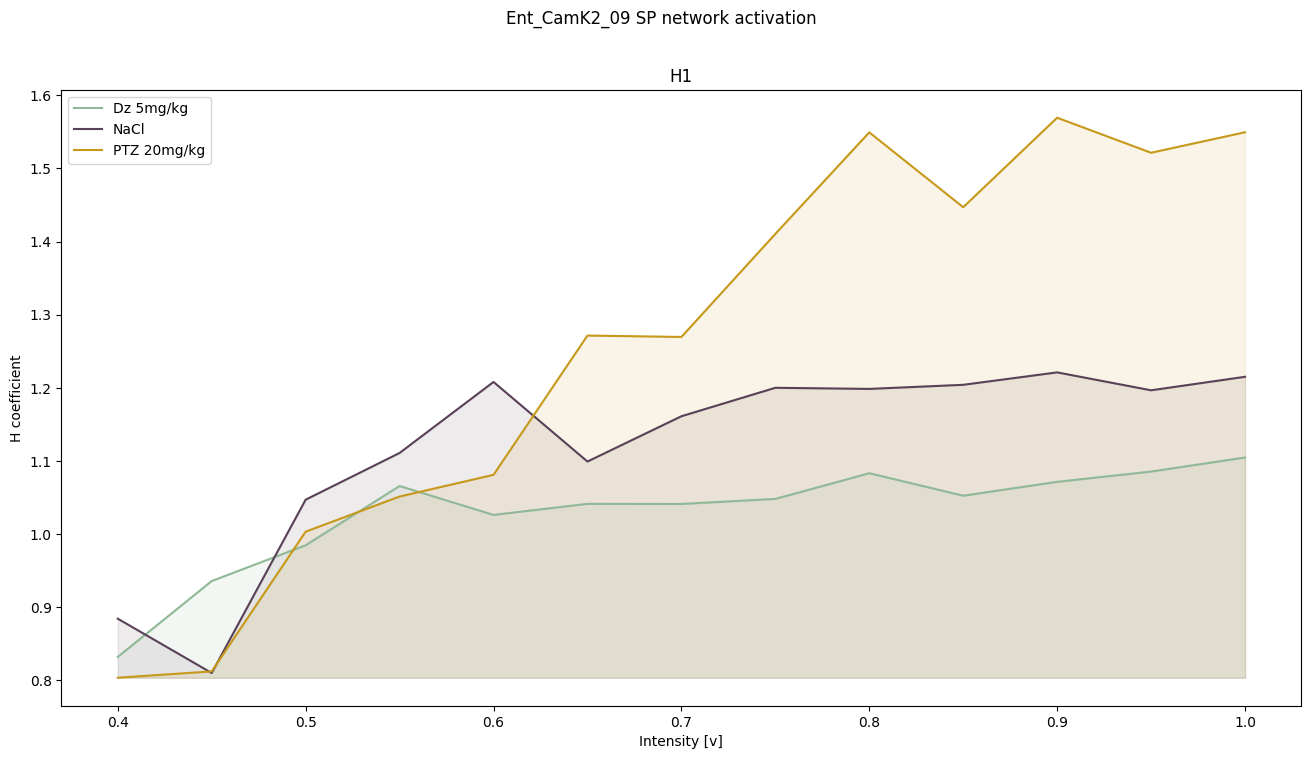

In [56]:
# Plot network activation function (H) as a function of stimulation intensities and pharmalogical conditions
H_matrix = SP_df_animal.loc[:,['Session','Intensity[v]', 'Onset[datapoints]', 'Condition', 'Block']] # Get information on each single pulse

# Add activation of each basis function (H1,H2,...)
for i_H in range(H.shape[0]):
        H_matrix['H'+str(i_H+1)] = H[i_H]

# Remove NaN values (artefacts)
H_matrix = H_matrix.loc[H_matrix['H1'] > 0,:]

# Plot network activation functions (H) as a function of stimulation intensities and pharmacological conditions
title = animal + ' SP network activation'
all_condition = np.unique(H_matrix['Condition']) 
H_all = [i for i in H_matrix.columns if i.startswith('H')] # Get all activation functions

fig = plt.figure(title, figsize=(16, 8)).suptitle(title)
gridspec.GridSpec(12, 12)

for i_h, Hs in enumerate(H_all):
    axx = plt.subplot2grid((12, 12), (0, int(i_h * (12 / len(H_all)))), rowspan=12, colspan=int(12 / len(H_all)))
    val_min = np.min(H_matrix.groupby(['Condition', 'Intensity[v]'])[Hs].mean())
    val_max = np.max(H_matrix.groupby(['Condition', 'Intensity[v]'])[Hs].mean())
    for idx_cnd,cnd in enumerate(all_condition):
        dat_c = H_matrix[(H_matrix.Condition == cnd)]
        Int_all = np.unique(dat_c['Intensity[v]'])
        H_mean = dat_c.groupby('Intensity[v]')[Hs].mean().values
        axx.plot(Int_all, H_mean, color=my_color_palette[cnd], label=cnd)
        axx.fill_between(Int_all, val_min, H_mean, color=my_color_palette[cnd], alpha=0.1)
    axx.set_title(Hs)
    axx.legend()
    axx.set_xlabel('Intensity [v]')
    if i_h == 0:
        axx.set_ylabel('H coefficient')

plt.subplots_adjust(wspace=0.9)

In [57]:
# For each session, calculate the input/output curve and measure the area under the curve

def NMF_SP_get_AUC_per_block(data, hue_order,animal, block):
    Int_all = np.unique(data['Intensity[v]'])
    all_condition = np.unique(data['Condition'])
    H_all = [i for i in data.columns if i.startswith('H')]
    conditions = np.array(hue_order)[np.isin(hue_order, all_condition)].tolist() # Remove condition not in the block from conditions

    list_AUC=[] ; list_Hs = [] ; list_cnd = []; list_session = []
    for i_h, Hs in enumerate(H_all):
        val_min = np.min(data.groupby(['Condition', 'Intensity[v]'])[Hs].mean())
        val_max = np.max(data.groupby(['Condition', 'Intensity[v]'])[Hs].mean())
        AUC1 = np.trapz(np.repeat(val_max, len(Int_all)) - val_min, Int_all)
        for idx_cnd,cnd in enumerate(conditions):
            dat_c = data[(data.Condition == cnd)]
            session = np.unique(data['Session'][(data.Condition == cnd)])[0]
            H_mean = dat_c.groupby('Intensity[v]')[Hs].mean().values
            AUC = np.trapz(H_mean - val_min, np.unique(dat_c['Intensity[v]'])) / AUC1
            list_AUC.append(AUC)
            list_Hs.append(Hs), list_cnd.append(cnd);list_session.append(session)

    info_df = {'Animal': [animal] * len(conditions), 'Session':list_session,'Block': [block] * len(conditions),'Condition':list_cnd,'H':list_Hs, 'AUC':list_AUC}
    AUC_df = pd.DataFrame(info_df)

    return AUC_df


AUC_df_per_block = []
all_block = H_matrix['Block'].unique()
for block in all_block:
    H_matrix_block = H_matrix.loc[H_matrix['Block'] == block, :]
    AUC_df = NMF_SP_get_AUC_per_block(H_matrix_block, all_condition, animal, block)
    AUC_df_per_block.append(AUC_df)

all_AUC_df = pd.concat(AUC_df_per_block, ignore_index=True)

In [60]:
all_block =  all_AUC_df['Block'].unique()
for block in all_block:
    all_AUC_df.loc[all_AUC_df['Block']==block,'Delta AUC'] = all_AUC_df.loc[all_AUC_df['Block']==block, 'AUC'] - float(all_AUC_df.loc[(all_AUC_df['Condition'] == 'NaCl') & (all_AUC_df['Block']==block), 'AUC'])
print(all_AUC_df)

         Animal Session  Block    Condition   H       AUC  Normalized AUC  \
0  Ent_CamK2_09     S04      0    Dz 5mg/kg  H1  0.279680             NaN   
1  Ent_CamK2_09     S03      0         NaCl  H1  0.391147             NaN   
2  Ent_CamK2_09     S01      0  PTZ 20mg/kg  H1  0.563530             NaN   
3  Ent_CamK2_09     S07      1    Dz 5mg/kg  H1  0.262193             NaN   
4  Ent_CamK2_09     S06      1         NaCl  H1  0.351809             NaN   
5  Ent_CamK2_09     S05      1  PTZ 20mg/kg  H1  0.655534             NaN   
6  Ent_CamK2_09     S11      2    Dz 5mg/kg  H1  0.279280             NaN   
7  Ent_CamK2_09     S10      2         NaCl  H1  0.400412             NaN   
8  Ent_CamK2_09     S09      2  PTZ 20mg/kg  H1  0.549460             NaN   

   Delta AUC  
0  -0.111468  
1   0.000000  
2   0.172383  
3  -0.089616  
4   0.000000  
5   0.303725  
6  -0.121132  
7   0.000000  
8   0.149049  
